In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from notebook_utils import load_data, train, accuracy_multiclass, run_test_data, NN, make_performance_uncertainty_plot
from torchsummary import summary

import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score

from torch import nn

In [3]:
train_loader, val_loader = load_data('/home/davidr/projects/class-weight-uncertainty/data/cats_dogs/', batch_size=64)

In [4]:
n_classes = 2

canonical = NN(n_classes=n_classes)
optimizer = torch.optim.Adam(canonical.parameters(), lr=1e-2)
loss_fn = torch.nn.functional.binary_cross_entropy_with_logits
print(summary(canonical, input_size=(3, 224, 224)))
# canonical = train(canonical, optimizer, loss_fn, 
#       train_loader, val_loader, class_weights=[0.5, 0.5], epochs=1)

canonical.eval()
canonical.load_state_dict(torch.load('canonical.pth', map_location='cpu'))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             224
       BatchNorm2d-2          [-1, 8, 222, 222]              16
              ReLU-3          [-1, 8, 222, 222]               0
         MaxPool2d-4          [-1, 8, 111, 111]               0
            Conv2d-5          [-1, 8, 109, 109]             584
       BatchNorm2d-6          [-1, 8, 109, 109]              16
              ReLU-7          [-1, 8, 109, 109]               0
         MaxPool2d-8            [-1, 8, 54, 54]               0
            Conv2d-9           [-1, 16, 52, 52]           1,168
      BatchNorm2d-10           [-1, 16, 52, 52]              32
             ReLU-11           [-1, 16, 52, 52]               0
        MaxPool2d-12           [-1, 16, 26, 26]               0
           Conv2d-13           [-1, 16, 24, 24]           2,320
      BatchNorm2d-14           [-1, 16,

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [5]:
canonical_outputs, canonical_labels = run_test_data(canonical, val_loader)

canonical_outputs = torch.sigmoid(canonical_outputs)

roc_auc_score(canonical_labels.numpy(), canonical_outputs.numpy())

100%|██████████| 40/40 [00:33<00:00,  1.20it/s]


0.97546944

In [6]:
overconfident = NN(n_classes=n_classes)
# overconfident.eval()

# for name, parameter in overconfident.fe.named_parameters():
#     weight = canonical_state_dict[name]
#     parameter.data = weight
#     parameter.requires_grad = False

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# overconfident_weight = torch.Tensor([2]).to(device)
    
# optimizer = torch.optim.Adam(overconfident.parameters(), lr=1e-2)
# loss_fn = torch.nn.functional.binary_cross_entropy_with_logits
# overconfident_weight = [0.4, 0.6]
# train(overconfident, optimizer, loss_fn, train_loader, val_loader, class_weights=overconfident_weight)

overconfident.eval()
overconfident.load_state_dict(torch.load('overconfident.pth', map_location='cpu'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [7]:
for name, parameter in overconfident.fe.named_parameters():
    print(parameter[0][0])
    break

tensor([[-0.0256,  0.2696,  0.2852],
        [-0.1184,  0.2506,  0.2734],
        [-0.1403, -0.0990,  0.3134]], grad_fn=<SelectBackward>)


In [8]:
for name, parameter in canonical.fe.named_parameters():
    print(parameter[0][0])
    break

tensor([[-0.0256,  0.2696,  0.2852],
        [-0.1184,  0.2506,  0.2734],
        [-0.1403, -0.0990,  0.3134]], grad_fn=<SelectBackward>)


In [9]:
underconfident = NN(n_classes=n_classes)
# underconfident.eval()

# for name, parameter in underconfident.fe.named_parameters():
#     weight = canonical_state_dict[name]
#     parameter.data = weight
#     parameter.requires_grad = False

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# underconfident_weight = torch.Tensor([2]).to(device)
    
# optimizer = torch.optim.Adam(underconfident.parameters(), lr=1e-2)
# loss_fn = torch.nn.functional.binary_cross_entropy_with_logits
# underconfident_weight = [0.6, 0.4]
# # train(underconfident, optimizer, loss_fn, train_loader, val_loader, class_weights=underconfident_weight)
underconfident.eval()
underconfident.load_state_dict(torch.load('underconfident.pth', map_location='cpu'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [10]:
underconfident.eval().cpu()
canonical.eval().cpu()
overconfident.eval().cpu()

NN(
  (fe): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (13): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ce

In [11]:
with torch.no_grad():
    outputs_val = [run_test_data(underconfident, val_loader), 
                   run_test_data(canonical, val_loader), 
                   run_test_data(overconfident, val_loader)]

100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


In [12]:
labels_val = [output[1] for output in outputs_val]
outputs_val = [output[0] for output in outputs_val]

In [13]:
labels_val = labels_val[0]

In [14]:
outputs_val = torch.stack([torch.sigmoid(output) for output in outputs_val], dim=-1).numpy()

In [15]:
outputs_val.shape

(2500, 3)

In [16]:
test_labels = labels_val
test_labels.shape, outputs_val[:, 1].shape

(torch.Size([2500]), (2500,))

In [17]:
roc_auc_score(test_labels, outputs_val[:, 1])

0.97546944

In [45]:
uncertainties = outputs_val[:, 2] - outputs_val[:, 0]

Text(0, 0.5, 'Uncertainty')

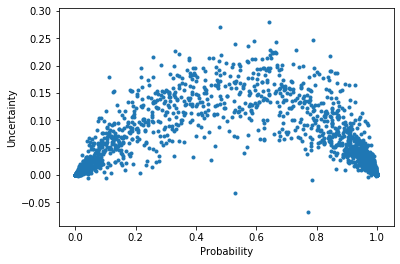

In [46]:
plt.scatter(outputs_val[:, 1], uncertainties, marker='.')
plt.xlabel('Probability')
plt.ylabel('Uncertainty')


In [47]:
outputs_val.shape

(2500, 3)

In [48]:
outputs_val[:, 0].mean(), outputs_val[:, 1].mean(), outputs_val[:, 2].mean()

(0.48447686, 0.516629, 0.52774036)

In [ ]:
train_labels = torch.cat([batch[1] for batch in train_loader]).numpy()

cutoff = np.percentile(outputs_val[:, 1], 100 * (1-train_labels.mean()))
cutoff

In [52]:
preds = outputs_val[:, 1] > cutoff

In [53]:
wrong_preds = (preds != test_labels)

In [54]:
roc_auc_score(wrong_preds, uncertainties)

0.8741088516746411

In [55]:
average_precision_score(wrong_preds, uncertainties)

0.3438184814111496

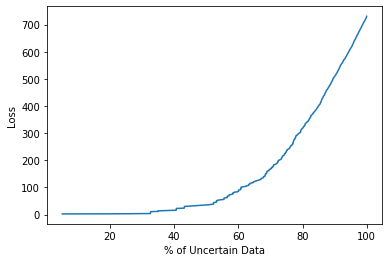

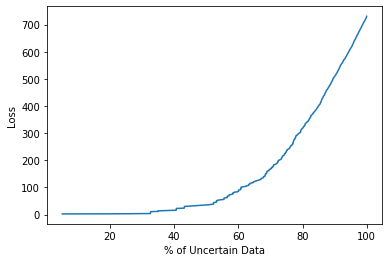

In [56]:
make_performance_uncertainty_plot(test_labels, outputs_val[:, 1], uncertainties, 'Loss', performance_fn_args={'reduction': 'sum'})

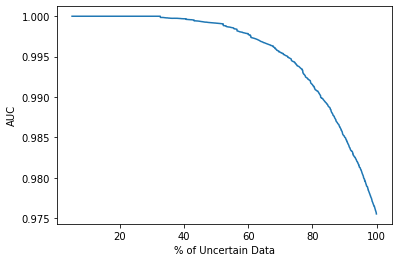

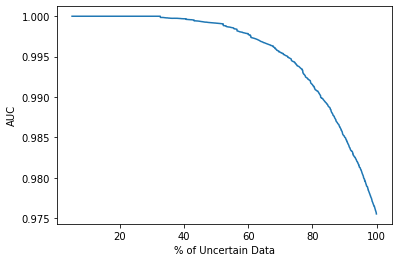

In [57]:
make_performance_uncertainty_plot(test_labels, outputs_val[:, 1], uncertainties, 'AUC', performance_fn=roc_auc_score)

In [58]:
def asymmetric_entropy(p, w):
    return (p * (1 - p)) / ((-2 * w + 1) * p + w ** 2)


# uncertainties = asymmetric_entropy(outputs_val[:, 5], y_train.values.mean())
uncertainties = asymmetric_entropy(outputs_val[:, 1], cutoff)

In [59]:
roc_auc_score(wrong_preds, uncertainties)

0.8959928229665073

In [60]:
average_precision_score(wrong_preds, uncertainties)

0.4087474106032363

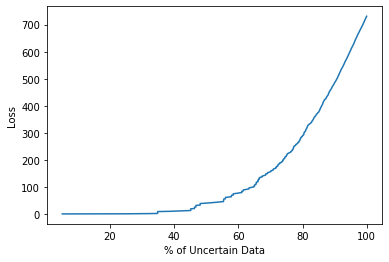

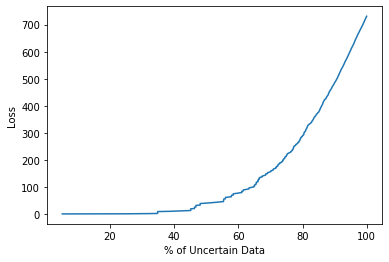

In [61]:
make_performance_uncertainty_plot(test_labels, outputs_val[:, 1], uncertainties, 'Loss', performance_fn_args={'reduction': 'sum'})

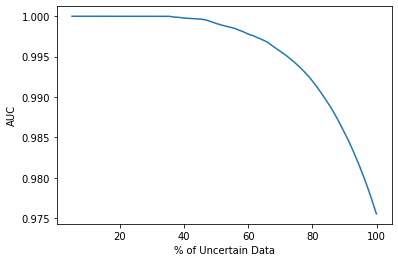

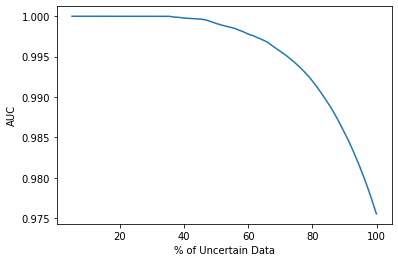

In [62]:
make_performance_uncertainty_plot(test_labels, outputs_val[:, 1], uncertainties, 'AUC', performance_fn=roc_auc_score)